<a href="https://colab.research.google.com/github/surpha/VQA-SOP/blob/main/VQA_PrevWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For using GUI, execute all the cells below a cell of "##########----------##########" (after having trained the model once and saved the checkpoints).
GUI is in the Markdown section near the bottom of this notebook.

##########----------##########

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


##########----------##########

In [ ]:
train = '/content/drive/MyDrive/VQA/VQA_v2/train2014/train2014'
val = '/content/drive/MyDrive/VQA/VQA_v2/val2014/val2014'
test = '/content/drive/MyDrive/VQA/VizWiz/test'

##########----------##########

In [ ]:
# coding: utf-8
import sys
sys.path.insert(0,'/content/drive/MyDrive/VQA/VQA_v2/VQA-master/PythonHelperTools/vqaTools')

##########----------##########

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import tqdm as tqdm
import shutil

import time
from contextlib import contextmanager
import os, argparse
import cv2, spacy, numpy as np
# from sklearn.externals import joblib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import re
import gc

import csv
import glob
# set the matplotlib backend so figures can be saved in the background
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg")
# import the necessary packages

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn import preprocessing
from sklearn.metrics import classification_report

from imutils import paths
import math
import numpy as np
import pickle
import operator
from operator import itemgetter
from itertools import zip_longest
from collections import defaultdict
import json
import joblib
from tqdm import tqdm
import pandas as pd
from nltk.tokenize.treebank import TreebankWordTokenizer
import pandas as pd
import seaborn as sns
import datetime

%matplotlib inline

##########----------##########

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU, add, Conv2D, Reshape
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D, multiply
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, VGG19, ResNet101, EfficientNetB5
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.utils import Sequence
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image, text, sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')


##########----------##########

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

##########----------##########

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

##########----------##########

In [ ]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 37.6 MB/s eta 0:00:00


##########----------##########

In [ ]:
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

In [ ]:
image_folder = '/content/drive/MyDrive/VQA/VQA_v2/Data/train2014/'
image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=image_folder,
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)

 4507926528/13510573713 [=========>....................] - ETA: 13:27

KeyboardInterrupt: ignored

In [ ]:
image_folder = '/content/drive/MyDrive/VQA/VQA_v2/Data/test2015/'
image_zip = tf.keras.utils.get_file('test2015.zip',
                                      cache_subdir=image_folder,
                                      origin = 'http://images.cocodataset.org/zips/test2015.zip',
                                      extract = True)
#####
# Extract is false in the reference code
#####

13270587935/13270587935 [==============================] - 272s 0us/step


In [ ]:
len(os.listdir('/content/drive/MyDrive/VQA/VQA_v2/Data/test2014/test2014'))

FileNotFoundError: ignored

##########----------##########

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# DO NOT EXECUTE THIS
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
!unzip "/content/drive/MyDrive/VQA/VQA_v2/Data/train2014/train2014.zip" -d "/content/train2014/"

Streaming output truncated to the last 5000 lines.
 extracting: /content/train2014/train2014/COCO_train2014_000000408557.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000013714.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000194043.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000219859.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000278135.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000141015.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000280923.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000200024.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000435713.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000249993.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000424160.jpg  
 extracting: /content/train2014/train2014/COCO_train2014_000000142761.jpg  
 extracting: /content/train2014/train

In [ ]:
!unzip "/content/drive/MyDrive/VQA/VQA_v2/Data/test2015/test2015.zip" -d "/content/test2015/"

Streaming output truncated to the last 5000 lines.
 extracting: /content/test2015/test2015/COCO_test2015_000000303195.jpg  
 extracting: /content/test2015/test2015/COCO_test2015_000000481207.jpg  
 extracting: /content/test2015/test2015/COCO_test2015_000000229167.jpg  
 extracting: /content/test2015/test2015/COCO_test2015_000000466120.jpg  
 extracting: /content/test2015/test2015/COCO_test2015_000000237368.jpg  
 extracting: /content/test2015/test2015/COCO_test2015_000000009689.jpg  
 extracting: /content/test2015/test2015/COCO_test2015_000000064513.jpg  
 extracting: /content/test2015/test2015/COCO_test2015_000000058293.jpg  
 extracting: /content/test2015/test2015/COCO_test2015_000000449819.jpg  
 extracting: /content/test2015/test2015/COCO_test2015_000000106852.jpg  
 extracting: /content/test2015/test2015/COCO_test2015_000000227623.jpg  
 extracting: /content/test2015/test2015/COCO_test2015_000000250613.jpg  
 extracting: /content/test2015/test2015/COCO_test2015_000000347395.jpg  


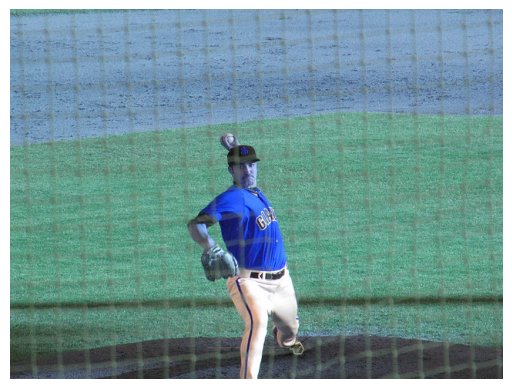

In [ ]:
from matplotlib import pyplot as plt
import cv2
img_unchanged = cv2.imread('/content/train2014/train2014/COCO_train2014_000000458752.jpg',-1)
plt.imshow(img_unchanged)
plt.axis("off")
plt.show()

In [ ]:
import json
import datetime
import copy

class VQA:
  def __init__(self, annotation_file=None, question_file=None):
  # load dataset
    self.dataset = {}
    self.questions = {}
    self.qa = {}
    self.qqa = {}
    self.imgToQA = {}
    if not annotation_file == None and not question_file == None:
      print('loading VQA annotations and questions into memory...')
      time_t = datetime.datetime.utcnow()
      dataset = json.load(open(annotation_file, 'r'))
      questions = json.load(open(question_file, 'r'))
      print(datetime.datetime.utcnow() - time_t)
      self.dataset = dataset
      self.questions = questions
      self.createIndex()

  def createIndex(self):
        # create index
    print('creating index...')
    imgToQA = {ann['image_id']: [] for ann in self.dataset['annotations']}
    qa =  {ann['question_id']:       [] for ann in self.dataset['annotations']}
    qqa = {ann['question_id']:       [] for ann in self.dataset['annotations']}
    for ann in self.dataset['annotations']:
      imgToQA[ann['image_id']] += [ann]
      qa[ann['question_id']] = ann
    for ques in self.questions['questions']:
        qqa[ques['question_id']] = ques
    print('index created!')

 		# create class members
    self.qa = qa
    self.qqa = qqa
    self.imgToQA = imgToQA

  def info(self):
    """
    Print information about the VQA annotation file.
    :return:
    """
    for key, value in self.datset['info'].items():
      print('%s: %s'%(key, value))

  def getQuesIds(self, imgIds=[], quesTypes=[], ansTypes=[]):
    """
    Get question ids that satisfy given filter conditions. default skips that filter
    :param 	imgIds    (int array)   : get question ids for given imgs
        quesTypes (str array)   : get question ids for given question types
        ansTypes  (str array)   : get question ids for given answer types
    :return:    ids   (int array)   : integer array of question ids
    """
    imgIds 	  = imgIds    if type(imgIds)    == list else [imgIds]
    quesTypes = quesTypes if type(quesTypes) == list else [quesTypes]
    ansTypes  = ansTypes  if type(ansTypes)  == list else [ansTypes]

    if len(imgIds) == len(quesTypes) == len(ansTypes) == 0:
      anns = self.dataset['annotations']
    else:
      if not len(imgIds) == 0:
        anns = sum([self.imgToQA[imgId] for imgId in imgIds if imgId in self.imgToQA],[])
      else:
        anns = self.dataset['annotations']
      anns = anns if len(quesTypes) == 0 else [ann for ann in anns if ann['question_type'] in quesTypes]
      anns = anns if len(ansTypes)  == 0 else [ann for ann in anns if ann['answer_type'] in ansTypes]
    ids = [ann['question_id'] for ann in anns]
    return ids

  def getImgIds(self, quesIds=[], quesTypes=[], ansTypes=[]):
    """
    Get image ids that satisfy given filter conditions. default skips that filter
    :param quesIds   (int array)   : get image ids for given question ids
                quesTypes (str array)   : get image ids for given question types
                ansTypes  (str array)   : get image ids for given answer types
    :return: ids     (int array)   : integer array of image ids
    """
    quesIds   = quesIds   if type(quesIds)   == list else [quesIds]
    quesTypes = quesTypes if type(quesTypes) == list else [quesTypes]
    ansTypes  = ansTypes  if type(ansTypes)  == list else [ansTypes]

    if len(quesIds) == len(quesTypes) == len(ansTypes) == 0:
      anns = self.dataset['annotations']
    else:
      if not len(quesIds) == 0:
        anns = sum([self.qa[quesId] for quesId in quesIds if quesId in self.qa],[])
      else:
        anns = self.dataset['annotations']
      anns = anns if len(quesTypes) == 0 else [ann for ann in anns if ann['question_type'] in quesTypes]
      anns = anns if len(ansTypes)  == 0 else [ann for ann in anns if ann['answer_type'] in ansTypes]
    ids = [ann['image_id'] for ann in anns]
    return ids

  def loadQA(self, ids=[]):
    """
    Load questions and answers with the specified question ids.
    :param ids (int array)       : integer ids specifying question ids
    :return: qa (object array)   : loaded qa objects
    """
    if type(ids) == list:
      return [self.qa[id] for id in ids]
    elif type(ids) == int:
      return [self.qa[ids]]

  def showQA(self, anns):
    """
    Display the specified annotations.
    :param anns (array of object): annotations to display
    :return: None
    """
    if len(anns) == 0:
      return 0
    for ann in anns:
      quesId = ann['question_id']
      print("Question: %s" %(self.qqa[quesId]['question']))
      for ans in ann['answers']:
        print("Answer %d: %s" %(ans['answer_id'], ans['answer']))

  def loadRes(self, resFile, quesFile):
    """
    Load result file and return a result object.
    :param   resFile (str)     : file name of result file
    :return: res (obj)         : result api object
    """
    res = VQA()
    res.questions = json.load(open(quesFile))
    res.dataset['info'] = copy.deepcopy(self.questions['info'])
    res.dataset['task_type'] = copy.deepcopy(self.questions['task_type'])
    res.dataset['data_type'] = copy.deepcopy(self.questions['data_type'])
    res.dataset['data_subtype'] = copy.deepcopy(self.questions['data_subtype'])
    res.dataset['license'] = copy.deepcopy(self.questions['license'])

    print('Loading and preparing results...     ')
    time_t = datetime.datetime.utcnow()
    anns    = json.load(open(resFile))
    assert type(anns) == list, 'results is not an array of objects'
    annsQuesIds = [ann['question_id'] for ann in anns]
    assert set(annsQuesIds) == set(self.getQuesIds()), \
    'Results do not correspond to current VQA set. Either the results do not have predictions for all question ids in annotation file or there is atleast one question id that does not belong to the question ids in the annotation file.'
    for ann in anns:
      quesId 			     = ann['question_id']
      if res.dataset['task_type'] == 'Multiple Choice':
        assert ann['answer'] in self.qqa[quesId]['multiple_choices'], 'predicted answer is not one of the multiple choices'
      qaAnn                = self.qa[quesId]
      ann['image_id']      = qaAnn['image_id']
      ann['question_type'] = qaAnn['question_type']
      ann['answer_type']   = qaAnn['answer_type']
    print('DONE (t=%0.2fs)'%((datetime.datetime.utcnow() - time_t).total_seconds()))

    res.dataset['annotations'] = anns
    res.createIndex()
    return res


In [ ]:
import random
import skimage.io as io

dataDir		='/content/drive/MyDrive/VQA/VQA_v2'
versionType ='' # this should be '' when using VQA v2.0 dataset
taskType    ='OpenEnded' # 'OpenEnded' only for v2.0. 'OpenEnded' or 'MultipleChoice' for v1.0
dataType    ='mscoco'  # 'mscoco' only for v1.0. 'mscoco' for real and 'abstract_v002' for abstract for v1.0.
dataSubType ='train2014'
annFile     ='/content/drive/MyDrive/VQA/VQA_v2/mscoco_train2014_annotations.json'
quesFile    ='/content/drive/MyDrive/VQA/VQA_v2/OpenEnded_mscoco_train2014.json'
imgDir 		= '/content/train2014/train2014/'

# initialize VQA api for QA annotations
vqa=VQA(annFile, quesFile)

loading VQA annotations and questions into memory...
0:00:08.972485
creating index...
index created!


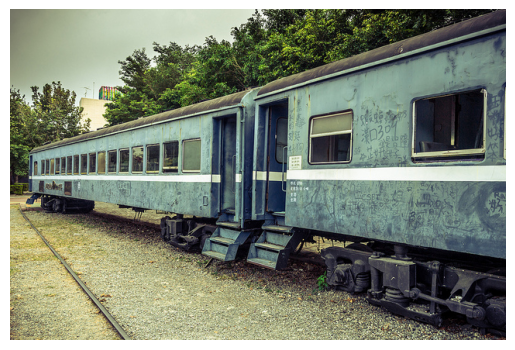

In [ ]:
imgId = 78077
imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
I = io.imread(imgDir + imgFilename)
plt.imshow(I)
plt.axis('off')
plt.show()

Question: vahaan kitne bear bear hai
Answer 1: 2
Answer 2: 2
Answer 3: 2
Answer 4: 2
Answer 5: 2
Answer 6: 2
Answer 7: 2
Answer 8: 2
Answer 9: 2
Answer 10: 2


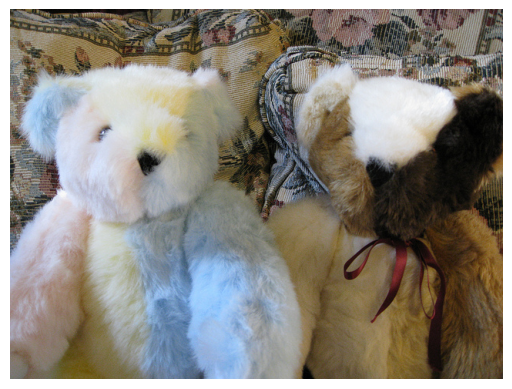

In [ ]:

# load and display QA annotations for given question types
"""
All possible quesTypes for abstract and mscoco has been provided in respective text files in ../QuestionTypes/ folder.
"""
annIds = vqa.getQuesIds(quesTypes='how many');
anns = vqa.loadQA(annIds)
randomAnn = random.choice(anns)
vqa.showQA([randomAnn])
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
if os.path.isfile(imgDir + imgFilename):
  I = io.imread(imgDir + imgFilename)
  plt.imshow(I)
  plt.axis('off')
  plt.show()

Question: kya ek new image he
Answer 1: no
Answer 2: no
Answer 3: no
Answer 4: no
Answer 5: no
Answer 6: no
Answer 7: no
Answer 8: no
Answer 9: no
Answer 10: no


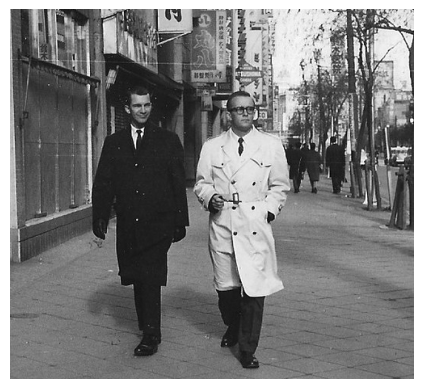

In [ ]:
# load and display QA annotations for given answer types
"""
ansTypes can be one of the following
yes/no
number
other
"""
annIds = vqa.getQuesIds(ansTypes='yes/no');
anns = vqa.loadQA(annIds)
randomAnn = random.choice(anns)
vqa.showQA([randomAnn])
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
if os.path.isfile(imgDir + imgFilename):
	I = io.imread(imgDir + imgFilename)
	plt.imshow(I)
	plt.axis('off')
	plt.show()

Question: kya yah duplicate yaa real dikhataa he
Answer 1: fake
Answer 2: fake
Answer 3: real
Answer 4: fake
Answer 5: fake
Answer 6: fake
Answer 7: fake
Answer 8: fake
Answer 9: fake
Answer 10: fake


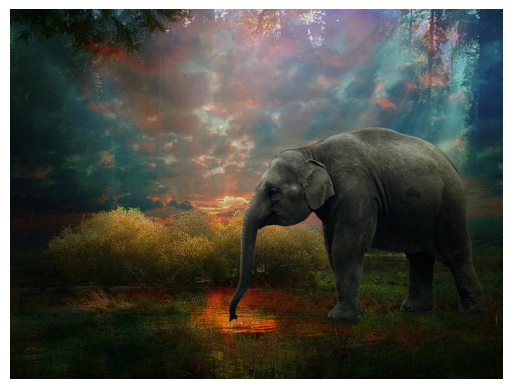

In [ ]:
# load and display QA annotations for given images
"""
Usage: vqa.getImgIds(quesIds=[], quesTypes=[], ansTypes=[])
Above method can be used to retrieve imageIds for given question Ids or given question types or given answer types.
"""
ids = vqa.getImgIds()
annIds = vqa.getQuesIds(imgIds=random.sample(ids,5));
anns = vqa.loadQA(annIds)
randomAnn = random.choice(anns)
vqa.showQA([randomAnn])
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType + '_'+ str(imgId).zfill(12) + '.jpg'
if os.path.isfile(imgDir + imgFilename):
	I = io.imread(imgDir + imgFilename)
	plt.imshow(I)
	plt.axis('off')
	plt.show()

In [ ]:
len(anns)

15

In [ ]:
anns[5]

{'question_type': 'does this',
 'multiple_choice_answer': 'fake',
 'answers': [{'answer': 'fake', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'fake', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'real', 'answer_confidence': 'maybe', 'answer_id': 3},
  {'answer': 'fake', 'answer_confidence': 'maybe', 'answer_id': 4},
  {'answer': 'fake', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'fake', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'fake', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'fake', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'fake', 'answer_confidence': 'maybe', 'answer_id': 9},
  {'answer': 'fake', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 32244,
 'answer_type': 'other',
 'question_id': 322442}

In [ ]:
def getAllAnswer(answers_list):
	"""
	Joins a list of answers by ";" to a single string

	Input:
		answer_list: list of answers (there are 10 answers for every question)

	Returns:
		A string in the format "ans1;ans2;...;ans10"
	"""
	answers = []
	for i in range(len(answers_list)):
		answers.append(answers_list[i]['answer'])
	return ';'.join(answers)

In [ ]:
def process_question_annotation(subset):
    """
    Creates a JSON file whose elements are (image_path, question, answer, answers)
    from the Questions and Annotations files.

    Input:
      subset: subset can be "train2014" or "val2014"

    Returns:
      None
    """
    anno = json.load(open(f'/content/drive/MyDrive/VQA/VQA_v2/v2_mscoco_{subset}_annotations.json', 'r'))
    ques = json.load(open(f'/content/drive/MyDrive/VQA/VQA_v2/v2_OpenEnded_mscoco_{subset}_questions.json', 'r'))
    imdir='%s/COCO_%s_%012d.jpg' ## COCO_train2014_000000291417.jpg
    data = []

    for i in tqdm(range(len(anno['annotations']))):
        image_path = '/content/drive/MyDrive/VQA/VQA_v2/'+imdir%(subset, subset, anno['annotations'][i]['image_id'])
        question = ques['questions'][i]['question']
        ans = anno['annotations'][i]['multiple_choice_answer']
        answer_list = getAllAnswer(anno['annotations'][i]['answers'])
        data.append({'img_path': image_path, 'question': question, 'ans': ans, 'answers': answer_list})

    json.dump(data, open(f'/content/drive/MyDrive/VQA/VQA_v2/processed/vqa_raw_{subset}.json', 'w'))

In [ ]:
def process_test_question(subset):
    """
    Creates a JSON file whose elements are (image_path, question, questionID)
    from the Questions files.

    Input:
      subset: subset can be "test-dev2015" or "test2015"

    Returns:
      None
    """
    ques = json.load(open(f'/content/drive/MyDrive/VQA/VQA_v2/v2_OpenEnded_mscoco_{subset}_questions.json', 'r'))
    imdir='%s/%s/COCO_%s_%012d.jpg' ## COCO_train2014_000000291417.jpg
    data = []

    for i in tqdm(range(len(ques['questions']))):
        image_path = '/content/'+imdir%('test2015', 'test2015', subset, ques['questions'][i]['image_id'])
        question = ques['questions'][i]['question']
        qid = ques['questions'][i]['question_id']
        data.append({'img_path': image_path, 'question': question, 'question_id': qid})

    json.dump(data, open(f'/content/drive/MyDrive/VQA/VQA_v2/processed/vqa_raw_{subset}.json', 'w'))

In [ ]:
subset = 'val2014'
process_question_annotation(subset)

100%|██████████| 214354/214354 [00:00<00:00, 348863.48it/s]


In [ ]:
subset = ['test-dev2015','test2015']

for x in subset:
  process_test_question(x)

100%|██████████| 447793/447793 [00:00<00:00, 887268.62it/s]


In [ ]:
subset = 'test-dev2015'
testdev_data = json.load(open(f'/content/drive/MyDrive/VQA/VQA_v2/processed/vqa_raw_{subset}.json', 'r'))
subset = 'test2015'
test_data = json.load(open(f'/content/drive/MyDrive/VQA/VQA_v2/processed/vqa_raw_{subset}.json', 'r'))

In [ ]:
ques = json.load(open(f'/content/drive/MyDrive/VQA/VQA_v2/OpenEnded_mscoco_train2014.json', 'r'))

In [ ]:
def process_question_annotation(subset):
    """
    Creates a JSON file whose elements are (image_path, question, answer, answers)
    from the Questions and Annotations files.

    Input:
      subset: subset can be "train2014" or "val2014"

    Returns:
      None
    """
    anno = json.load(open(f'/content/drive/MyDrive/VQA/VQA_v2/mscoco_train2014_annotations.json', 'r'))
    ques = json.load(open(f'/content/drive/MyDrive/VQA/VQA_v2/OpenEnded_mscoco_train2014.json', 'r'))
    imdir='%s/COCO_%s_%012d.jpg' ## COCO_train2014_000000291417.jpg
    data = []

    for i in tqdm(range(len(anno['annotations']))):
        image_path = '/content/drive/MyDrive/VQA/VQA_v2/'+imdir%(subset, subset, anno['annotations'][i]['image_id'])
        question = ques['questions'][i]['question']
        ans = anno['annotations'][i]['multiple_choice_answer']
        answer_list = getAllAnswer(anno['annotations'][i]['answers'])
        data.append({'img_path': image_path, 'question': question, 'ans': ans, 'answers': answer_list})

    json.dump(data, open(f'/content/drive/MyDrive/VQA/VQA_v2/processed/vqa_raw_{subset}.json', 'w'))

In [ ]:
process_question_annotation('train2014')

100%|██████████| 248349/248349 [00:00<00:00, 360615.87it/s]


In [ ]:
subset = 'train2014'
train_data = json.load(open(f'/content/drive/MyDrive/VQA/VQA_v2/processed/vqa_raw_{subset}.json', 'r'))
subset = 'val2014'
val_data = json.load(open(f'/content/drive/MyDrive/VQA/VQA_v2/processed/vqa_raw_{subset}.json', 'r'))

In [ ]:
train_data[:20]

[{'img_path': '/content/drive/MyDrive/VQA/VQA_v2/train2014/COCO_train2014_000000487025.jpg',
  'question': 'bench take kya size he',
  'ans': 'curved',
  'answers': 'oval;semi circle;curved;curved;double curve;banana;curved;wavy;twisting;curved'},
 {'img_path': '/content/drive/MyDrive/VQA/VQA_v2/train2014/COCO_train2014_000000487025.jpg',
  'question': 'kya koi chaaya he',
  'ans': 'yes',
  'answers': 'yes;yes;yes;yes;yes;yes;yes;yes;yes;yes'},
 {'img_path': '/content/drive/MyDrive/VQA/VQA_v2/train2014/COCO_train2014_000000487025.jpg',
  'question': 'kya yah ek when yaa multiple when he',
  'ans': '1',
  'answers': '1;multiple;1;1;multiple;multiple;1;multiple;1;multiple'},
 {'img_path': '/content/drive/MyDrive/VQA/VQA_v2/train2014/COCO_train2014_000000078077.jpg',
  'question': 'kya yah ek modern train he',
  'ans': 'no',
  'answers': 'no;no;no;no;no;no;no;no;no;no'},
 {'img_path': '/content/drive/MyDrive/VQA/VQA_v2/train2014/COCO_train2014_000000078077.jpg',
  'question': 'train par b

In [ ]:
test_data[:2]

[{'img_path': '/content/test2015/test2015/COCO_test2015_000000262144.jpg',
  'question': 'Is the ball flying towards the batter?',
  'question_id': 262144000},
 {'img_path': '/content/test2015/test2015/COCO_test2015_000000262144.jpg',
  'question': 'What sport is this?',
  'question_id': 262144001}]

In [ ]:
testdev_data[:2]

[{'img_path': '/content/test2015/test2015/COCO_test-dev2015_000000262144.jpg',
  'question': 'What credit card company is on the banner in the background?',
  'question_id': 262144005},
 {'img_path': '/content/test2015/test2015/COCO_test-dev2015_000000262144.jpg',
  'question': 'Is the pitcher wearing a hat?',
  'question_id': 262144003}]

In [ ]:
train_data[:2]

[{'img_path': '/content/drive/MyDrive/VQA/VQA_v2/train2014/COCO_train2014_000000487025.jpg',
  'question': 'bench take kya size he',
  'ans': 'curved',
  'answers': 'oval;semi circle;curved;curved;double curve;banana;curved;wavy;twisting;curved'},
 {'img_path': '/content/drive/MyDrive/VQA/VQA_v2/train2014/COCO_train2014_000000487025.jpg',
  'question': 'kya koi chaaya he',
  'ans': 'yes',
  'answers': 'yes;yes;yes;yes;yes;yes;yes;yes;yes;yes'}]

In [ ]:
val_data[:2]

[{'img_path': '/content/drive/MyDrive/VQA/VQA_v2/val2014/COCO_val2014_000000262148.jpg',
  'question': 'Where is he looking?',
  'ans': 'down',
  'answers': 'down;down;at table;skateboard;down;table;down;down;down;down'},
 {'img_path': '/content/drive/MyDrive/VQA/VQA_v2/val2014/COCO_val2014_000000262148.jpg',
  'question': 'What are the people in the background doing?',
  'ans': 'watching',
  'answers': 'spectating;watching;watching;watching;watching;watching;watching;watching;watching;watching'}]

In [ ]:
answer_freq = defaultdict(int)
for answer in list(map(itemgetter('ans'), train_data)):
		answer_freq[answer] += 1
print('There are total ', len(answer_freq), ' different types of answers.')

There are total  17140  different types of answers.


In [ ]:
max_answers = 1000

In [ ]:
def selectTopAnswersData(questions_list, answer_list, answers_list, images_list, k):
	"""
	Reduces the train dataset to contain only the datapoints whose answer occurence is in top k

	Input:
		questions_list: list of questions
		answer_list: list of most frequent answer
		answers_list: list of answers
		images_list: list of image path
		k: number of top answers

	Returns:
		Returns tuple of reduced dataset and the top k answers (questions_list, answer_list, answers_list, images_list, top_answers)
	"""
	answer_freq= defaultdict(int)

	for answer in answer_list:
		answer_freq[answer] += 1

	sorted_freq = sorted(answer_freq.items(), key=operator.itemgetter(1), reverse=True)[0: k]
	top_answers, top_freq = zip(*sorted_freq)

	new_questions_list=[]
	new_answer_list=[]
	new_answers_list=[]
	new_images_list=[]

	for question, answer, answers, image in zip(questions_list, answer_list, answers_list, images_list):
		if answer in top_answers:
			new_questions_list.append(question)
			new_answer_list.append(answer)
			new_answers_list.append(answers)
			new_images_list.append(image)

	print('Training Data size reduced by', np.round(((len(questions_list)-len(new_questions_list))/len(questions_list))*100, 2),'%')
	return(new_questions_list, new_answer_list, new_answers_list, new_images_list, top_answers)

In [ ]:
questions_train, answer_train, answers_train, images_train, top_answers = selectTopAnswersData(list(map(itemgetter('question'), train_data)),
                                                                                               list(map(itemgetter('ans'), train_data)),
                                                                                               list(map(itemgetter('answers'), train_data)),
                                                                                               list(map(itemgetter('img_path'), train_data)), max_answers)

Training Data size reduced by 13.28 %


In [ ]:
def filterTopAnswersData(questions_list, answer_list, answers_list, images_list, top_answers):
	"""
	Reduces the validation dataset to contain only the datapoints whose answer is in top_answers

	Input:
		questions_list: list of questions
		answer_list: list of most frequent answer
		answers_list: list of answers
		images_list: list of image path
		top_answers: list of top answers

	Returns:
		Returns tuple of reduced dataset (questions_list, answer_list, answers_list, images_list)
	"""
	new_questions_list=[]
	new_answer_list=[]
	new_answers_list=[]
	new_images_list=[]

	for question, answer, answers, image in zip(questions_list, answer_list, answers_list, images_list):
		if answer in top_answers:
			new_questions_list.append(question)
			new_answer_list.append(answer)
			new_answers_list.append(answers)
			new_images_list.append(image)

	print('Validation Data size reduced by', np.round(((len(questions_list)-len(new_questions_list))/len(questions_list))*100, 2),'%')
	return (new_questions_list, new_answer_list, new_answers_list, new_images_list)

In [ ]:
questions_val, answer_val, answers_val, images_val = filterTopAnswersData(list(map(itemgetter('question'), val_data)),
                                                                          list(map(itemgetter('ans'), val_data)),
                                                                          list(map(itemgetter('answers'), val_data)),
                                                                          list(map(itemgetter('img_path'), val_data)), top_answers)

Validation Data size reduced by 13.2 %


In [ ]:
questions_test, questionid_test, images_test = (list(map(itemgetter('question'), test_data)),
                                                                          list(map(itemgetter('question_id'), test_data)),
                                                                          list(map(itemgetter('img_path'), test_data)))

In [ ]:
print(len(questions_test),len(questionid_test),len(images_test))

447793 447793 447793


In [ ]:
# # save to disk
with open('/content/drive/MyDrive/VQA/VQA_v2/processed/vqa_raw_test2015sep.json', 'wb') as f:
  joblib.dump((questions_test, questionid_test, images_test), f)

In [ ]:
# loading from disk
with open('/content/drive/MyDrive/VQA/VQA_v2/processed/vqa_raw_test2015sep.json', 'rb') as f:
  questions_test, questionid_test, images_test = joblib.load(f)

In [ ]:
# # save to disk
with open('/content/drive/MyDrive/VQA/VQA_v2/processed/vqa_raw_train2014_top1000.json', 'wb') as f:
  joblib.dump((questions_train, answer_train, answers_train, images_train), f)

with open('/content/drive/MyDrive/VQA/VQA_v2/processed/vqa_raw_val2014_top1000.json', 'wb') as f:
  joblib.dump((questions_val, answer_val, answers_val, images_val), f)

In [ ]:
# loading from disk
with open('/content/drive/MyDrive/VQA/VQA_v2/processed/vqa_raw_train2014_top1000.json', 'rb') as f:
  questions_train, answer_train, answers_train, images_train = joblib.load(f)

with open('/content/drive/MyDrive/VQA/VQA_v2/processed/vqa_raw_val2014_top1000.json', 'rb') as f:
  questions_val, answer_val, answers_val, images_val = joblib.load(f)

In [ ]:
print(len(questions_train), len(answer_train), len(answers_train), len(images_train))

215375 215375 215375 215375


##########----------##########

In [ ]:
from PIL import Image

In [ ]:
print(questions_train[:3])
print(answer_train[:3])
print(answers_train[:3])
print(images_train[:3])

['kya koi chaaya he', 'kya yah ek when yaa multiple when he', 'kya yah ek modern train he']
['yes', '1', 'no']
['yes;yes;yes;yes;yes;yes;yes;yes;yes;yes', '1;multiple;1;1;multiple;multiple;1;multiple;1;multiple', 'no;no;no;no;no;no;no;no;no;no']
['/content/drive/MyDrive/VQA/VQA_v2/train2014/COCO_train2014_000000487025.jpg', '/content/drive/MyDrive/VQA/VQA_v2/train2014/COCO_train2014_000000487025.jpg', '/content/drive/MyDrive/VQA/VQA_v2/train2014/COCO_train2014_000000078077.jpg']


In [ ]:
print(len(questions_val), len(answer_val), len(answers_val), len(images_val))

186067 186067 186067 186067


### Image Featurization

##########----------##########

In [ ]:
train_img_dir = '/content/train2014/train2014/'
val_img_dir = '/content/drive/MyDrive/VQA/VQA_v2/Data/val2014/val2014/'
test_img_dir = '/content/test2015/test2015/'

##########----------##########

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 119.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 126.6 MB/s eta 0:00:00


##########----------##########

In [ ]:
from transformers import ViTModel

model = ViTModel.from_pretrained('google/vit-base-patch16-224')

model.eval()

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

##########----------##########

In [ ]:
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

##########----------##########

In [ ]:
pip install vit-keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=1ce7b2958c89f31e198d4bd6cceb0f4a1c0447dbdd06e02bbf60b35e4481699a
  Stored in directory: /root/.cache/pip/wheels/f2/ed/dd/d3a556ad245ef9dc570c6bcd2f22886d17b0b408dd3bbb9ac3
Successfully built validators


##########----------##########

In [ ]:
from vit_keras import vit, utils
image_size = 224
model = vit.vit_l32(
    image_size=image_size,
    pretrained=True,
    include_top=False,
    pretrained_top=False
)

1226658854/1226658854 [==============================] - 42s 0us/step


##########----------##########

In [ ]:
model.summary()

Model: "vit-l32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 1024)        3146752   
                                                                 
 reshape (Reshape)           (None, 49, 1024)          0         
                                                                 
 class_token (ClassToken)    (None, 50, 1024)          1024      
                                                                 
 Transformer/posembed_input   (None, 50, 1024)         51200     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 1024),       12596224  
 (TransformerBlock)           (None, 16, None, None))      

##########----------##########

In [ ]:
last_layer = model.get_layer('Transformer/encoder_norm')
output = last_layer.output

##########----------##########

In [ ]:
output = output[:,1:]

##########----------##########

In [ ]:
model2 = Model(model.input, model.layers[-2].output[:,1:])

##########----------##########

In [ ]:
output.shape

TensorShape([None, 49, 1024])

##########----------##########

In [ ]:
model = EfficientNetB5(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

115263384/115263384 [==============================] - 6s 0us/step


##########----------##########

In [ ]:
last_layer = model.get_layer('top_activation')
output = last_layer.output

##########----------##########

In [ ]:
output = Conv2D(filters = 512, kernel_size=(1,1))(output)

##########----------##########

In [ ]:
model2 = Model(model.input, output)

##########----------##########

In [ ]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']    

In [ ]:
def image_feature_extractor(target_path, image_list, BATCH_SIZE, img_dir):
	"""
	Extracts (512, 7, 7)-dimensional CNN features and save them locally

	Input:
		target_path: path to save the features
		image_list: image filenames
		BATCH_SIZE: batch size

	Returns:
		None
	"""

	model = ResNet101(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

  	# add a progress bar
	progbar = tf.keras.utils.Progbar(int(np.ceil(len(image_list) / float(BATCH_SIZE))))

  	# loop over the images in batches
	for (b, i) in enumerate(range(0, len(image_list), BATCH_SIZE)):
		# extract batch of images and prepare them to pass it through the VGG
		# network for feature extraction

		progbar.update(b+1)

		batch_range = range(i, min(i + BATCH_SIZE, len(image_list)))
		batchPaths = image_list[batch_range[0]: batch_range[-1]+1]

		batchImages = []
		batchIds = []
		# loop over the images and labels in the current batch
		for imagePath in batchPaths:

            # load the input image using the Keras helper utility
            # while ensuring the image is resized to 224x224 pixels
			img = image.load_img(os.path.join(img_dir,imagePath), target_size=(224, 224))
			img = image.img_to_array(img)

            # preprocess the image by
            # (1) expanding the dimensions to include batch dim and
            # (2) subtracting the mean RGB pixel intensity from the ImageNet dataset
			img = np.expand_dims(img, axis=0)
			img = preprocess_input(img)

            # add the image to the batch
			batchImages.append(img)
			# image ids of the batch
			batchIds.append(imagePath.split('.')[0][-6:])

		batchImages = np.vstack(batchImages) # (BATCH_SIZE, 3, 224, 224)

		# pass the images through the network and use the outputs as our actual features
		features = model2.predict(batchImages) # (BATCH_SIZE, 512, 7, 7)
		features = tf.reshape(features, (features.shape[0], features.shape[3], -1)) # (BATCH_SIZE, 512, 49)
		features = tf.transpose(features, perm =[0,2,1])  # (BATCH_SIZE, 49, 512)
		print(features.shape)

		# loop over the batch to save them locally
		for id, feat in zip(batchIds, features):
			np.save(os.path.join(target_path, id), feat)

In [ ]:
image_list = os.listdir(train_img_dir)
BATCH_SIZE = 300
target_path = '/content/features'

In [ ]:
image_list_test = os.listdir('/content/test2015/test2015')
BATCH_SIZE = 300
target_path_test = '/content/test_features'

FileNotFoundError: ignored

In [ ]:
len(image_list)

82783

In [ ]:
image_list[1]

'COCO_train2014_000000338894.jpg'

In [ ]:
!rm -rf /content/train2014

##########----------##########

In [ ]:
from tensorflow.keras.preprocessing import image, text, sequence

In [ ]:
image_feature_extractor(target_path, image_list, BATCH_SIZE, train_img_dir)

10/10 [==============================] - 2s 188ms/step
(300, 49, 512)
10/10 [==============================] - 2s 187ms/step
(300, 49, 512)
10/10 [==============================] - 2s 188ms/step
(300, 49, 512)
10/10 [==============================] - 2s 189ms/step
(300, 49, 512)
10/10 [==============================] - 2s 186ms/step
(300, 49, 512)
10/10 [==============================] - 2s 186ms/step
(300, 49, 512)
10/10 [==============================] - 2s 186ms/step
(300, 49, 512)
10/10 [==============================] - 2s 188ms/step
(300, 49, 512)
10/10 [==============================] - 2s 188ms/step
(300, 49, 512)
10/10 [==============================] - 2s 185ms/step
(300, 49, 512)
10/10 [==============================] - 2s 186ms/step
(300, 49, 512)
10/10 [==============================] - 2s 186ms/step
(300, 49, 512)
10/10 [==============================] - 2s 184ms/step
(300, 49, 512)
10/10 [==============================] - 2s 185ms/step
(300, 49, 512)
10/10 [=============

In [ ]:
ft = np.load('/content/features/078077.npy')

In [ ]:
ft.shape

(49, 512)

In [ ]:
ft

array([[-3.18983823e-01, -1.78631581e-02, -1.93842381e-01, ...,
         1.02478015e+00,  7.80127272e-02,  5.38081694e+00],
       [-4.80426222e-01,  9.97730613e-01, -1.20558107e+00, ...,
        -7.34465933e+00, -5.98975563e+00, -2.19341087e+00],
       [ 8.37600052e-01,  1.37435591e+00, -5.35836756e-01, ...,
        -8.39902115e+00,  1.28756011e+00,  3.76801395e+00],
       ...,
       [-1.22660875e-01, -5.18463831e-03,  6.45820737e-01, ...,
         4.10743999e+00,  1.82058465e+00,  3.11143064e+00],
       [-1.63595349e-01,  1.13051724e+00, -6.51517212e-01, ...,
         2.23136973e+00,  1.02349329e+00, -4.77656174e+00],
       [-6.93181157e-02,  4.72294629e-01,  1.19801509e+00, ...,
        -2.81701565e+00, -1.49413836e+00, -5.38981104e+00]], dtype=float32)

In [ ]:
s = np.load('/content/features/342255.npy')

In [ ]:
s.shape

(49, 512)

In [ ]:
! du -sh /content/train2014/train2014

13G	/content/train2014/train2014


### Text Featurization

##########----------##########

In [ ]:
import re

def process_sentence(sentence):
    periodStrip  = re.compile("(?!<=\d)(\.)(?!\d)")
    commaStrip   = re.compile("(\d)(\,)(\d)")
    punct        = [';', r"/", '[', ']', '"', '{', '}',
                    '(', ')', '=', '+', '\\', '_', '-',
                    '>', '<', '@', '`', ',', '?', '!']
    contractions = {"aint": "ain't", "arent": "aren't", "cant": "can't", "couldve": "could've", "couldnt": "couldn't", \
                    "couldn'tve": "couldn't've", "couldnt've": "couldn't've", "didnt": "didn't", "doesnt": "doesn't", "dont": "don't", "hadnt": "hadn't", \
                    "hadnt've": "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent": "haven't", "hed": "he'd", "hed've": "he'd've", \
                    "he'dve": "he'd've", "hes": "he's", "howd": "how'd", "howll": "how'll", "hows": "how's", "Id've": "I'd've", "I'dve": "I'd've", \
                    "Im": "I'm", "Ive": "I've", "isnt": "isn't", "itd": "it'd", "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", "let's": "let's", \
                    "maam": "ma'am", "mightnt": "mightn't", "mightnt've": "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've", \
                    "mustnt": "mustn't", "mustve": "must've", "neednt": "needn't", "notve": "not've", "oclock": "o'clock", "oughtnt": "oughtn't", \
                    "ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat": "'ow's'at", "shant": "shan't", "shed've": "she'd've", "she'dve": "she'd've", \
                    "she's": "she's", "shouldve": "should've", "shouldnt": "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve": "shouldn't've", \
                    "somebody'd": "somebodyd", "somebodyd've": "somebody'd've", "somebody'dve": "somebody'd've", "somebodyll": "somebody'll", \
                    "somebodys": "somebody's", "someoned": "someone'd", "someoned've": "someone'd've", "someone'dve": "someone'd've", \
                    "someonell": "someone'll", "someones": "someone's", "somethingd": "something'd", "somethingd've": "something'd've", \
                    "something'dve": "something'd've", "somethingll": "something'll", "thats": "that's", "thered": "there'd", "thered've": "there'd've", \
                    "there'dve": "there'd've", "therere": "there're", "theres": "there's", "theyd": "they'd", "theyd've": "they'd've", \
                    "they'dve": "they'd've", "theyll": "they'll", "theyre": "they're", "theyve": "they've", "twas": "'twas", "wasnt": "wasn't", \
                    "wed've": "we'd've", "we'dve": "we'd've", "weve": "we've", "werent": "weren't", "whatll": "what'll", "whatre": "what're", \
                    "whats": "what's", "whatve": "what've", "whens": "when's", "whered": "where'd", "wheres": "where's", "whereve": "where've", \
                    "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl": "who'll", "whos": "who's", "whove": "who've", "whyll": "why'll", \
                    "whyre": "why're", "whys": "why's", "wont": "won't", "wouldve": "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've", \
                    "wouldn'tve": "wouldn't've", "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've", \
                    "y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've", \
                    "youll": "you'll", "youre": "you're", "youve": "you've"}

    inText = sentence.replace('\n', ' ')
    inText = inText.replace('\t', ' ')
    inText = inText.strip()
    outText = inText
    for p in punct:
        if (p + ' ' in inText or ' ' + p in inText) or \
           (re.search(commaStrip, inText) != None):
            outText = outText.replace(p, '')
        else:
            outText = outText.replace(p, ' ')
    outText = periodStrip.sub("", outText, re.UNICODE)
    outText = outText.lower().split()
    for wordId, word in enumerate(outText):
        if word in contractions:
            outText[wordId] = contractions[word]
    outText = ' '.join(outText)
    return outText

In [ ]:
sentence = "I aint doing somebodys"
process_sentence(sentence)

"i ain't doing somebody's"

In [ ]:
questions_train_processed = pd.Series(questions_train).apply(process_sentence)
questions_val_processed = pd.Series(questions_val).apply(process_sentence)

In [ ]:
questions_test_processed = pd.Series(questions_test).apply(process_sentence)

In [ ]:
# # save to disk
with open('/content/drive/MyDrive/VQA/VQA_v2/processed/processed_test_questions.pkl', 'wb') as f:
  joblib.dump(questions_test_processed, f)

In [ ]:
# load from disk
with open('/content/drive/MyDrive/VQA/VQA_v2/processed/processed_test_questions.pkl', 'rb') as f:
  questions_test_processed = joblib.load(f)

In [ ]:
# # save to disk
with open('/content/drive/MyDrive/VQA/VQA_v2/processed/processed_questions.pkl', 'wb') as f:
  joblib.dump((questions_train_processed, questions_val_processed), f)

In [ ]:
# load from disk
with open('/content/drive/MyDrive/VQA/VQA_v2/processed/processed_questions.pkl', 'rb') as f:
  questions_train_processed, questions_val_processed = joblib.load(f)

##########----------##########

In [ ]:
tok=text.Tokenizer(filters='')
tok.fit_on_texts(questions_train_processed)

In [ ]:
# # save to disk
with open('/content/drive/MyDrive/VQA/VQA_v2/text_tokenizer.pkl', 'wb') as f:
  joblib.dump(tok, f)

In [ ]:
# load from disk
with open('/content/drive/MyDrive/VQA/VQA_v2/text_tokenizer.pkl', 'rb') as f:
  tok = joblib.load(f)

In [ ]:
question_data_train = tok.texts_to_sequences(questions_train_processed)
question_data_val = tok.texts_to_sequences(questions_val_processed)

In [ ]:
question_data_test = tok.texts_to_sequences(questions_test_processed)

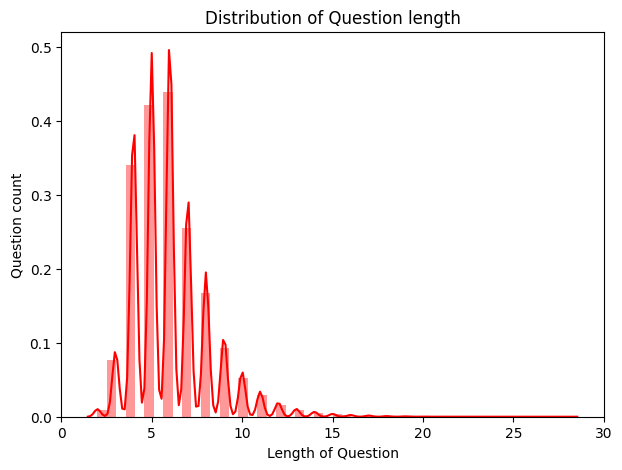

In [ ]:
question_len = [len(text) for text in question_data_train]
plt.figure(figsize=(7,5))
sns.distplot(question_len, color='red')
plt.title('Distribution of Question length')
plt.xlabel('Length of Question')
plt.ylabel('Question count')
plt.xlim(0, 30)
plt.show()

In [ ]:
for i in range(0,11):
    print(10*i,'percentile value is', np.percentile(question_len,10*i))

0 percentile value is 2.0
10 percentile value is 4.0
20 percentile value is 4.0
30 percentile value is 5.0
40 percentile value is 5.0
50 percentile value is 6.0
60 percentile value is 6.0
70 percentile value is 7.0
80 percentile value is 7.0
90 percentile value is 9.0
100 percentile value is 28.0


In [ ]:
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(question_len,90+i))

90 percentile value is 9.0
91 percentile value is 9.0
92 percentile value is 9.0
93 percentile value is 9.0
94 percentile value is 10.0
95 percentile value is 10.0
96 percentile value is 10.0
97 percentile value is 11.0
98 percentile value is 12.0
99 percentile value is 13.0
100 percentile value is 28.0


In [ ]:
for i in range(0,11):
    print(99+0.1*i,'percentile value is',np.percentile(question_len,99+0.1*i))

99.0 percentile value is 13.0
99.1 percentile value is 13.0
99.2 percentile value is 13.0
99.3 percentile value is 14.0
99.4 percentile value is 14.0
99.5 percentile value is 14.0
99.6 percentile value is 15.0
99.7 percentile value is 15.0
99.8 percentile value is 16.0
99.9 percentile value is 17.0
100.0 percentile value is 28.0


In [ ]:
for i in range(0,11):
    print(99.9+0.01*i,'percentile value is',np.percentile(question_len,99.9+0.01*i))

99.9 percentile value is 17.0
99.91000000000001 percentile value is 18.0
99.92 percentile value is 18.0
99.93 percentile value is 18.0
99.94000000000001 percentile value is 18.0
99.95 percentile value is 19.0
99.96000000000001 percentile value is 19.0
99.97 percentile value is 20.0
99.98 percentile value is 20.0
99.99000000000001 percentile value is 21.0
100.0 percentile value is 28.0


In [ ]:
for i in range(0,11):
    print(99.99+0.001*i,'percentile value is',np.percentile(question_len,99.99+0.001*i))

99.99 percentile value is 21.0
99.991 percentile value is 21.0
99.99199999999999 percentile value is 21.0
99.993 percentile value is 22.0
99.994 percentile value is 22.0
99.99499999999999 percentile value is 22.231299999984913
99.996 percentile value is 23.0
99.997 percentile value is 23.0
99.99799999999999 percentile value is 24.0
99.999 percentile value is 24.84625999999116
100.0 percentile value is 28.0


##########----------##########

In [ ]:
MAX_LEN = 28

In [ ]:
question_data_train=sequence.pad_sequences(question_data_train, maxlen=MAX_LEN, padding='post')
question_data_val=sequence.pad_sequences(question_data_val, maxlen=MAX_LEN, padding = 'post')

In [ ]:
question_data_test=sequence.pad_sequences(question_data_test, maxlen=MAX_LEN, padding = 'post')

In [ ]:
# # save to disk
with open('/content/drive/MyDrive/VQA/VQA_v2/tokenised_data_postpad.pkl', mode='wb') as f:
    pickle.dump((question_data_train, question_data_val), f)

In [ ]:
# load from disk
with open('/content/drive/MyDrive/VQA/VQA_v2/tokenised_data_postpad.pkl', mode='rb') as f:
    question_data_train, question_data_val = pickle.load(f)

In [ ]:
# # save to disk
with open('/content/drive/MyDrive/VQA/VQA_v2/tokenised_testdata_postpad.pkl', mode='wb') as f:
    pickle.dump(question_data_test, f)

In [ ]:
# load from disk
with open('/content/drive/MyDrive/VQA/VQA_v2/tokenised_testdata_postpad.pkl', mode='rb') as f:
    question_data_test = pickle.load(f)

### Answers

##########----------##########

In [ ]:
labelencoder = preprocessing.LabelEncoder()
labelencoder.fit(answer_train)

LabelEncoder()

##########----------##########

In [ ]:
labelencoder

LabelEncoder()

##########----------##########

In [ ]:
len(labelencoder.classes_)

1000

In [ ]:
# # save to disk
with open('/content/drive/MyDrive/VQA/VQA_v2/labelencoder.pkl', 'wb') as f:
  joblib.dump(labelencoder, f)

In [ ]:
# load from disk
with open('/content/drive/MyDrive/VQA/VQA_v2/labelencoder.pkl', 'rb') as f:
  labelencoder = joblib.load(f)

##########----------##########

In [ ]:
def get_answers_matrix(answers, encoder):
	'''
	One-hot-encodes the answers

	Input:
		answers:	list of answer
		encoder:	a scikit-learn LabelEncoder object

	Output:
		A numpy array of shape (# of answers, # of class)
	'''
	y = encoder.transform(answers) #string to numerical class
	nb_classes = encoder.classes_.shape[0]
	Y = tf.keras.utils.to_categorical(y, nb_classes)
	return Y

### Preparing Data

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size= 0.25,random_state=42)

for train_index, val_index in sss.split(images_train, answer_train):
  TRAIN_INDEX = train_index
  VAL_INDEX = val_index

In [ ]:
# image data
image_list_tr, image_list_vl = np.array(images_train)[TRAIN_INDEX.astype(int)], np.array(images_train)[VAL_INDEX.astype(int)]

In [ ]:
print(len(image_list_tr)+len(image_list_vl))

215375


In [ ]:
# question data
question_tr, question_vl = question_data_train[TRAIN_INDEX], question_data_train[VAL_INDEX]

In [ ]:
# answer data
answer_matrix = get_answers_matrix(answer_train, labelencoder)
answer_tr, answer_vl = answer_matrix[TRAIN_INDEX], answer_matrix[VAL_INDEX]

### Model

##########----------##########

In [ ]:
class AttentionMaps(tf.keras.layers.Layer):
  """
  Given an image feature map V ∈ R(d×N), and the question representation Q ∈ R(d×T),
  calculates the affinity matrix C ∈ R(T×N): C = tanh((QT)(Wb)V) ;
  where Wb ∈ R(d×d) contains the weights. (Refer eqt (3) section 3.3).

  Given this affinity matrix C ∈ R(T×N), predicts image and question attention maps
  (Refer eqt (4) section 3.3).

  Arguments:
    dim_k     : hidden attention dimention
    reg_value : Regularization value


  Inputs:
    image_feat,    V : shape (N,  d) or (49, dim_d)
    ques_feat,     Q : shape (T,  d) or (23, dim_d)

  Outputs:
    Image and Question attention maps viz:
    a) Hv = tanh(WvV + (WqQ)C) and
    b) Hq = tanh(WqQ + (WvV )CT)
  """
  def __init__(self, dim_k, reg_value, **kwargs):
    super(AttentionMaps, self).__init__(**kwargs)

    self.dim_k = dim_k
    self.reg_value = reg_value

    self.Wv = Dense(self.dim_k, activation=None,\
                        kernel_regularizer=tf.keras.regularizers.l2(self.reg_value),\
                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=2))
    self.Wq = Dense(self.dim_k, activation=None,\
                        kernel_regularizer=tf.keras.regularizers.l2(self.reg_value),\
                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=3))

  def call(self, image_feat, ques_feat):
    """
    The main logic of this layer.
    """

    # Affinity Matrix C
    # (QT)(Wb)V
    C = tf.matmul(ques_feat, tf.transpose(image_feat, perm=[0,2,1])) # [b, 23, 49]
    # tanh((QT)(Wb)V)
    C = tf.keras.activations.tanh(C)

    # (Wv)V
    WvV = self.Wv(image_feat)                             # [b, 49, dim_k]
    # (Wq)Q
    WqQ = self.Wq(ques_feat)                              # [b, 23, dim_k]

    # ((Wq)Q)C
    WqQ_C = tf.matmul(tf.transpose(WqQ, perm=[0,2,1]), C) # [b, k, 49]
    WqQ_C = tf.transpose(WqQ_C, perm =[0,2,1])            # [b, 49, k]

    # ((Wv)V)CT                                           # [b, k, 23]
    WvV_C = tf.matmul(tf.transpose(WvV, perm=[0,2,1]), tf.transpose(C, perm=[0,2,1]))

    WvV_C = tf.transpose(WvV_C, perm =[0,2,1])            # [b, 23, k]

    #---------------image attention map------------------
    # We find "Hv = tanh((Wv)V + ((Wq)Q)C)" ; H_v shape [49, k]

    H_v = WvV + WqQ_C                                     # (Wv)V + ((Wq)Q)C
    H_v = tf.keras.activations.tanh(H_v)                  # tanh((Wv)V + ((Wq)Q)C)

    #---------------question attention map---------------
    # We find "Hq = tanh((Wq)Q + ((Wv)V)CT)" ; H_q shape [23, k]

    H_q = WqQ + WvV_C                                     # (Wq)Q + ((Wv)V)CT
    H_q = tf.keras.activations.tanh(H_q)                  # tanh((Wq)Q + ((Wv)V)CT)

    return [H_v, H_q]                                     # [b, 49, k], [b, 23, k]

  def get_config(self):
    """
    This method collects the input shape and other information about the layer.
    """
    config = {
        'dim_k': self.dim_k,
        'reg_value': self.reg_value
    }
    base_config = super(AttentionMaps, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [ ]:
layer = AttentionMaps(64, 0.001)
config = layer.get_config()
print(config)
new_layer = AttentionMaps.from_config(config)

{'name': 'attention_maps', 'trainable': True, 'dtype': 'float32', 'dim_k': 64, 'reg_value': 0.001}


##########----------##########

In [ ]:
class ContextVector(tf.keras.layers.Layer):
  """
  Method to find context vector of the image and text features
  (Refer eqt (4) and (5) section 3.3).

  Arguments:
    reg_value : Regularization value

  Inputs:
    image_feat V: image features, (49, d)
    ques_feat  Q: question features, (23, d)
    H_v: image attention map, (49, k)
    H_q: question attention map, (23, k)

  Outputs:
    Returns d-dimenstional context vector for image and question features
  """
  def __init__(self, reg_value, **kwargs):
    super(ContextVector, self).__init__(**kwargs)

    self.reg_value = reg_value

    self.w_hv = Dense(1, activation='softmax',\
                        kernel_regularizer=tf.keras.regularizers.l2(self.reg_value),\
                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=4))
    self.w_hq = Dense(1, activation='softmax',\
                        kernel_regularizer=tf.keras.regularizers.l2(self.reg_value),\
                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=5))


  def call(self, image_feat, ques_feat, H_v, H_q):
    """
    The main logic of this layer.
    """
    # attention probabilities of each image region vn; a_v = softmax(wT_hv * H_v)
    a_v = self.w_hv(H_v)                               # [b, 49, 1]

    # attention probabilities of each word qt ;        a_q = softmax(wT_hq * H_q)
    a_q = self.w_hq(H_q)                               # [b, 23, 1]

    # context vector for image
    v = a_v * image_feat                               # [b, 49, dim_d]
    v = tf.reduce_sum(v, 1)                            # [b, dim_d]

    # context vector for question
    q = a_q * ques_feat                                # [b, 23, dim_d]
    q = tf.reduce_sum(q, 1)                            # [b, dim_d]


    return [v, q]

  def get_config(self):
    """
    This method collects the input shape and other information about the layer.
    """
    config = {
        'reg_value': self.reg_value
    }
    base_config = super(ContextVector, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [ ]:
layer = ContextVector(0.001)
config = layer.get_config()
print(config)
new_layer = ContextVector.from_config(config)

{'name': 'context_vector', 'trainable': True, 'dtype': 'float32', 'reg_value': 0.001}


##########----------##########

In [ ]:
class PhraseLevelFeatures(tf.keras.layers.Layer):
  """
  We compute the phrase features by applying 1-D convolution on the word embedding
  vectors with filters of three window sizes: unigram, bigram and trigram.
  The word-level features Qw are appropriately 0-padded before feeding into bigram and
  trigram convolutions to maintain the length of the sequence after convolution.
  Given the convolution result, we then apply max-pooling across different n-grams at each word
  location to obtain phrase-level features
  (Refer eqt (1) and (2) section 3.2).

  Arguments:
    dim_d: hidden dimension

  Inputs:
    word_feat Q : word level features of shape (23, dim_d)

  Outputs:
    Phrase level features of the question of shape (23, dim_d)
  """
  def __init__(self, dim_d, **kwargs):
    super(PhraseLevelFeatures, self).__init__(**kwargs)

    self.dim_d = dim_d

    self.conv_unigram = Conv1D(self.dim_d, kernel_size=1, strides=1,\
                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=6))
    self.conv_bigram =  Conv1D(self.dim_d, kernel_size=2, strides=1, padding='same',\
                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=7))
    self.conv_trigram = Conv1D(self.dim_d, kernel_size=3, strides=1, padding='same',\
                            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=8))


  def call(self, word_feat):
    """
    The main logic of this layer.

    Compute the n-gram phrase embeddings (n=1,2,3)
    """
    # phrase level unigram features
    x_uni = self.conv_unigram(word_feat)                    # [b, 23, dim_d]

    # phrase level bigram features
    x_bi  = self.conv_bigram(word_feat)                     # [b, 23, dim_d]

    # phrase level trigram features
    x_tri = self.conv_trigram(word_feat)                    # [b, 23, dim_d]

    # Concat
    x = tf.concat([tf.expand_dims(x_uni, -1),\
                    tf.expand_dims(x_bi, -1),\
                    tf.expand_dims(x_tri, -1)], -1)         # [b, 23, dim_d, 3]

    # https://stackoverflow.com/a/36853403
    # Max-pool across n-gram features; over-all phrase level feature
    x = tf.reduce_max(x, -1)                                # [b, 23, dim_d]

    return x

  def get_config(self):
    """
    This method collects the input shape and other information about the layer.
    """
    config = {
        'dim_d': self.dim_d
    }
    base_config = super(PhraseLevelFeatures, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [ ]:
layer = PhraseLevelFeatures(32)
config = layer.get_config()
print(config)
new_layer = PhraseLevelFeatures.from_config(config)

{'name': 'phrase_level_features', 'trainable': True, 'dtype': 'float32', 'dim_d': 32}


##########----------##########

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

##########----------##########

In [ ]:
pip install vit-keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##########----------##########

In [ ]:
from vit_keras import vit, utils
image_size = 224

##########----------##########

In [ ]:
vit_model = vit.vit_b32(image_size=image_size, pretrained=True,
                             include_top=False, pretrained_top=False)

353253686/353253686 [==============================] - 15s 0us/step


In [ ]:
def build_model(max_answers, max_seq_len, vocab_size, dim_d, dim_k, l_rate, d_rate, reg_value, vitmodel):
    """
    Defines the Keras model.

    Arguments
    ----------
    max_answers : Number of output targets of the model.
    max_seq_len : Length of input sequences
    vocab_size  : Size of the vocabulary, i.e. maximum integer index + 1.
    dim_d       : Hidden dimension
    dim_k       : Hidden attention dimension
    l_rate      : Learning rate for the model
    d_rate      : Dropout rate
    reg_value   : Regularization value

    Returns
    ----------
    Returns the Keras model.
    """
    # inputs
    image_input = Input(shape=(224, 224, 3, ), name='Image_Input')
    ques_input = Input(shape=(28, ), name='Question_Input')

    image_feat = vitmodel(image_input)

    # image feature; (Wb)V                                          # [b, 49, dim_d]
    image_feat = Dense(dim_d, activation=None, name='Image_Feat_Dense',\
                            kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1))(image_feat)
    image_feat = Dropout(d_rate, seed=1)(image_feat)

    # word level
    ques_feat_w = Embedding(input_dim=vocab_size, output_dim=dim_d, input_length=max_seq_len,\
                            mask_zero=True)(ques_input)

    Hv_w, Hq_w = AttentionMaps(dim_k, reg_value, name='AttentionMaps_Word')(image_feat, ques_feat_w)
    v_w, q_w = ContextVector(reg_value, name='ContextVector_Word')(image_feat, ques_feat_w, Hv_w, Hq_w)
    feat_w = tf.add(v_w,q_w)
    h_w = Dense(dim_d, activation='tanh', name='h_w_Dense',\
                    kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=13))(feat_w)

    # phrase level
    ques_feat_p = PhraseLevelFeatures(dim_d, name='PhraseLevelFeatures')(ques_feat_w)

    Hv_p, Hq_p = AttentionMaps(dim_k, reg_value, name='AttentionMaps_Phrase')(image_feat, ques_feat_p)
    v_p, q_p = ContextVector(reg_value, name='ContextVector_Phrase')(image_feat, ques_feat_p, Hv_p, Hq_p)
    feat_p = concatenate([tf.add(v_p,q_p), h_w], -1)
    h_p = Dense(dim_d, activation='tanh', name='h_p_Dense',\
                    kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=14))(feat_p)

    # sentence level
    ques_feat_s = LSTM(dim_d, return_sequences=True, input_shape=(None, max_seq_len, dim_d),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=16), use_bias=False)(ques_feat_p)

    Hv_s, Hq_s = AttentionMaps(dim_k, reg_value, name='AttentionMaps_Sent')(image_feat, ques_feat_s)
    v_s, q_s = ContextVector(reg_value, name='ContextVector_Sent')(image_feat, ques_feat_p, Hv_s, Hq_s)
    feat_s = concatenate([tf.add(v_s,q_s), h_p], -1)
    h_s = Dense(2*dim_d, activation='tanh', name='h_s_Dense',\
                    kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=15))(feat_s)

    z   = Dense(2*dim_d, activation='tanh', name='z_Dense',\
                    kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=16))(h_s)
    z   = Dropout(d_rate, seed=16)(z)

    # result
    result = Dense(max_answers, activation='softmax')(z)

    model = Model(inputs=[image_input, ques_input], outputs=result)

    return model

##########----------##########

In [ ]:
def build_model(max_answers, max_seq_len, vocab_size, dim_d, dim_k, l_rate, d_rate, reg_value):
    """
    Defines the Keras model.

    Arguments
    ----------
    max_answers : Number of output targets of the model.
    max_seq_len : Length of input sequences
    vocab_size  : Size of the vocabulary, i.e. maximum integer index + 1.
    dim_d       : Hidden dimension
    dim_k       : Hidden attention dimension
    l_rate      : Learning rate for the model
    d_rate      : Dropout rate
    reg_value   : Regularization value

    Returns
    ----------
    Returns the Keras model.
    """
    # inputs
    image_input = Input(shape=(49, 512, ), name='Image_Input')
    ques_input = Input(shape=(28, ), name='Question_Input')

    # image feature; (Wb)V                                          # [b, 49, dim_d]
    image_feat = Dense(dim_d, activation=None, name='Image_Feat_Dense',\
                            kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                                kernel_initializer=tf.keras.initializers.glorot_uniform(seed=1))(image_input)
    image_feat = Dropout(d_rate, seed=1)(image_feat)

    # word level
    ques_feat_w = Embedding(input_dim=vocab_size, output_dim=dim_d, input_length=max_seq_len,\
                            mask_zero=True)(ques_input)

    Hv_w, Hq_w = AttentionMaps(dim_k, reg_value, name='AttentionMaps_Word')(image_feat, ques_feat_w)
    v_w, q_w = ContextVector(reg_value, name='ContextVector_Word')(image_feat, ques_feat_w, Hv_w, Hq_w)
    feat_w = tf.add(v_w,q_w)
    h_w = Dense(dim_d, activation='tanh', name='h_w_Dense',\
                    kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=13))(feat_w)

    # phrase level
    ques_feat_p = PhraseLevelFeatures(dim_d, name='PhraseLevelFeatures')(ques_feat_w)

    Hv_p, Hq_p = AttentionMaps(dim_k, reg_value, name='AttentionMaps_Phrase')(image_feat, ques_feat_p)
    v_p, q_p = ContextVector(reg_value, name='ContextVector_Phrase')(image_feat, ques_feat_p, Hv_p, Hq_p)
    feat_p = concatenate([tf.add(v_p,q_p), h_w], -1)
    h_p = Dense(dim_d, activation='tanh', name='h_p_Dense',\
                    kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=14))(feat_p)

    # sentence level
    ques_feat_s = LSTM(dim_d, return_sequences=True, input_shape=(None, max_seq_len, dim_d),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=16), use_bias=True)(ques_feat_p)

    Hv_s, Hq_s = AttentionMaps(dim_k, reg_value, name='AttentionMaps_Sent')(image_feat, ques_feat_s)
    v_s, q_s = ContextVector(reg_value, name='ContextVector_Sent')(image_feat, ques_feat_p, Hv_s, Hq_s)
    feat_s = concatenate([tf.add(v_s,q_s), h_p], -1)
    h_s = Dense(2*dim_d, activation='tanh', name='h_s_Dense',\
                    kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=15))(feat_s)

    z   = Dense(2*dim_d, activation='tanh', name='z_Dense',\
                    kernel_regularizer=tf.keras.regularizers.l2(reg_value),\
                        kernel_initializer=tf.keras.initializers.glorot_uniform(seed=16))(h_s)
    z   = Dropout(d_rate, seed=16)(z)

    # result
    result = Dense(max_answers, activation='softmax')(z)

    model = Model(inputs=[image_input, ques_input], outputs=result)

    return model

### Create dataset


In [ ]:
!rm -rf /content/train2014_np

In [ ]:
base_dir = '/content/train2014/train2014'
target_dir = '/content/train2014_np'
images = os.listdir((base_dir))
for i in images:
  a = cv2.imread(os.path.join(base_dir,i))
  a = cv2.resize(a,(224,224))
  a = image.img_to_array(a)
  # preprocess the image by
  # (1) expanding the dimensions to include batch dim and
  # (2) subtracting the mean RGB pixel intensity from the ImageNet dataset
  #a = np.expand_dims(a, axis=0)
  a = preprocess_input(a)
  id = i.split('.')[0][-6:]
  np.save(os.path.join(target_dir, id), a)

In [ ]:
base_dir = '/content/test2015/test2015'
target_dir = '/content/test2015_np'
images = os.listdir((base_dir))
for i in images:
  a = cv2.imread(os.path.join(base_dir,i))
  a = cv2.resize(a,(224,224))
  a = image.img_to_array(a)
  # preprocess the image by
  # (1) expanding the dimensions to include batch dim and
  # (2) subtracting the mean RGB pixel intensity from the ImageNet dataset
  #a = np.expand_dims(a, axis=0)
  a = preprocess_input(a)
  id = i.split('.')[0][-6:]
  np.save(os.path.join(target_dir, id), a)

In [ ]:
len(os.listdir('/content/test2014/test2014'))

FileNotFoundError: ignored

In [ ]:
BATCH_SIZE = 300
BUFFER_SIZE = 5000

In [ ]:
def map_func(img_name, ques, ans):
    img_tensor = np.load('/content/features/' + img_name.decode('utf-8').split('.')[0][-6:] + '.npy')
    return img_tensor, ques, ans

In [ ]:
dataset_tr = tf.data.Dataset.from_tensor_slices((image_list_tr, question_tr, answer_tr))

# Use map to load the numpy files in parallel
dataset_tr = dataset_tr.map(lambda item1, item2, item3: tf.numpy_function(
    map_func, [item1, item2, item3], [tf.float32, tf.int32, tf.float32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset_tr = dataset_tr.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_tr = dataset_tr.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
dataset_vl = tf.data.Dataset.from_tensor_slices((image_list_vl, question_vl, answer_vl))

# Use map to load the numpy files in parallel
dataset_vl = dataset_vl.map(lambda item1, item2, item3: tf.numpy_function(
    map_func, [item1, item2, item3], [tf.float32, tf.int32, tf.float32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset_vl = dataset_vl.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_vl = dataset_vl.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
dataset_tr

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>

In [ ]:
# params 1
max_answers = 1000
max_seq_len = 28
vocab_size  = len(tok.word_index) + 1
EPOCHS      = 20

dim_d       = 512
dim_k       = 256
l_rate      = 1e-4
d_rate      = 0.5
reg_value   = 0.01

base_path = '/content/drive/MyDrive/VQA/VQA_v2/temps'

##########----------##########

In [ ]:
# Create Model
model = build_model(max_answers, max_seq_len, vocab_size, dim_d, dim_k, l_rate, d_rate, reg_value)

##########----------##########

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 49, 512)]    0           []                               
                                                                                                  
 Image_Feat_Dense (Dense)       (None, 49, 512)      262656      ['Image_Input[0][0]']            
                                                                                                  
 Question_Input (InputLayer)    [(None, 28)]         0           []                               
                                                                                                  
 dropout (Dropout)              (None, 49, 512)      0           ['Image_Feat_Dense[0][0]']       
                                                                                            

In [ ]:
steps_per_epoch = int(np.ceil(len(image_list_tr)/BATCH_SIZE))
boundaries      = [50*steps_per_epoch]
values          = [l_rate, l_rate/10]

In [ ]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]
        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed


In [ ]:
# we reduce the l_rate after 50th epoch (from 1e-4 to 1e-5)
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
optimizer        = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)

loss_object      = focal_loss(gamma=2, alpha=0.25)

In [ ]:
checkpoint_directory = base_path+"/training_checkpoints/"+str(l_rate)+"_"+str(dim_k)+"_EffB5_Focal"
SAVE_CKPT_FREQ = 5

In [ ]:
ckpt = tf.train.Checkpoint(step=tf.Variable(0), optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(ckpt, checkpoint_directory, max_to_keep=3)

In [ ]:
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)

In [ ]:
train_score = F1Score(num_classes=max_answers, average='micro', name='train_score')
val_score = F1Score(num_classes=max_answers, average='micro', name='val_score')

In [ ]:
train_log_dir = base_path+'/logs/'+str(l_rate)+"_"+str(dim_k)+'_EffB5_Focal'+'/train'
val_log_dir   = base_path+'/logs/'+str(l_rate)+"_"+str(dim_k)+'_EffB5_Focal'+'/validation'

train_summary_writer = tf.summary.create_file_writer(train_log_dir)
val_summary_writer = tf.summary.create_file_writer(val_log_dir)

In [ ]:
# @tf.function
def train_step(model, img, ques, ans, optimizer):
  with tf.GradientTape() as tape:
    # forward pass
    predictions = model([img, ques], training=True)
    loss = loss_object(ans, predictions)

  # backward pass
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  # record results
  train_loss(loss)
  train_score(ans, predictions)

  # all gradients
  grads_ = list(zip(grads, model.trainable_variables))
  return grads_

def test_step(model, img, ques, ans):
  predictions = model([img, ques])
  loss = loss_object(ans, predictions)

  # record results
  val_loss(loss)
  val_score(ans, predictions)

##########----------##########

In [ ]:
if manager.latest_checkpoint:
    ckpt.restore(manager.latest_checkpoint)
    print("Restored from {}".format(manager.latest_checkpoint))
    START_EPOCH = int(manager.latest_checkpoint.split('-')[-1]) * SAVE_CKPT_FREQ
    print("Resume training from epoch: {}".format(START_EPOCH))
else:
    print("Initializing from scratch")
    START_EPOCH = 0

Restored from /content/drive/MyDrive/VQA/VQA_v2/temps/training_checkpoints/0.0001_256_EffB5_Focal/ckpt-55
Resume training from epoch: 275


In [ ]:
START_EPOCH = 0

In [ ]:
for epoch in range(START_EPOCH, EPOCHS):

  start = time.time()

  for img, ques, ans in (dataset_tr):
    grads = train_step(model, img, ques, ans, optimizer)

  # tensorboard
  with train_summary_writer.as_default():
    # Create a summary to monitor cost tensor
    tf.summary.scalar('loss', train_loss.result(), step=epoch)
    # Create a summary to monitor accuracy tensor
    tf.summary.scalar('f1_score', train_score.result(), step=epoch)
    # Create summaries to visualize weights
    for var in model.trainable_variables:
        tf.summary.histogram(var.name, var, step=epoch)
    # Summarize all gradients
    for grad, var in grads:
        tf.summary.histogram(var.name + '/gradient', grad, step=epoch)

  for img, ques, ans in (dataset_vl):
    test_step(model, img, ques, ans)

  # tensorboard
  with val_summary_writer.as_default():
    # Create a summary to monitor cost tensor
    tf.summary.scalar('loss', val_loss.result(), step=epoch)
    # Create a summary to monitor accuracy tensor
    tf.summary.scalar('f1_score', val_score.result(), step=epoch)

  template = 'Epoch {}, loss: {:.4f}, f1_score: {:.4f}, val loss: {:.4f}, val f1_score: {:.4f}, time: {:.0f} sec'
  print (template.format(epoch + 1,
                         train_loss.result(),
                         train_score.result(),
                         val_loss.result(),
                         val_score.result(),
                         (time.time() - start)))

  # Reset metrics every epoch
  train_loss.reset_states()
  train_score.reset_states()
  val_loss.reset_states()
  val_score.reset_states()

  # save checkpoint every SAVE_CKPT_FREQ step
  ckpt.step.assign_add(1)
  if int(ckpt.step) % SAVE_CKPT_FREQ == 0:
      manager.save()
      print('Saved checkpoint.')

Epoch 1, loss: 0.2653, f1_score: 0.5136, val loss: 0.3769, val f1_score: 0.4481, time: 213 sec
Epoch 2, loss: 0.2640, f1_score: 0.5152, val loss: 0.3768, val f1_score: 0.4489, time: 214 sec
Epoch 3, loss: 0.2639, f1_score: 0.5158, val loss: 0.3769, val f1_score: 0.4487, time: 213 sec
Epoch 4, loss: 0.2624, f1_score: 0.5170, val loss: 0.3768, val f1_score: 0.4490, time: 213 sec
Saved checkpoint.
Epoch 5, loss: 0.2611, f1_score: 0.5183, val loss: 0.3765, val f1_score: 0.4489, time: 212 sec
Epoch 6, loss: 0.2608, f1_score: 0.5189, val loss: 0.3765, val f1_score: 0.4486, time: 214 sec
Epoch 7, loss: 0.2600, f1_score: 0.5199, val loss: 0.3766, val f1_score: 0.4489, time: 213 sec
Epoch 8, loss: 0.2591, f1_score: 0.5192, val loss: 0.3767, val f1_score: 0.4497, time: 213 sec
Epoch 9, loss: 0.2575, f1_score: 0.5208, val loss: 0.3762, val f1_score: 0.4488, time: 215 sec
Saved checkpoint.
Epoch 10, loss: 0.2573, f1_score: 0.5203, val loss: 0.3763, val f1_score: 0.4498, time: 213 sec
Epoch 11, los

In [ ]:
template = 'Epoch {}, loss: {:.4f}, f1_score: {:.4f}, val loss: {:.4f}, val f1_score: {:.4f}, time: {:.0f} sec'
print (template.format(epoch + 1,
                         train_loss.result(),
                         train_score.result(),
                         val_loss.result(),
                         val_score.result(),
                         (time.time() - start)))

Epoch 51, loss: 0.2581, f1_score: 0.5196, val loss: 0.3791, val f1_score: 0.4473, time: 442 sec


In [ ]:
for img, ques, ans in (dataset_vl):
  test_step(model, img, ques, ans)
with val_summary_writer.as_default():
    # Create a summary to monitor cost tensor
    tf.summary.scalar('loss', val_loss.result(), step=epoch)
    # Create a summary to monitor accuracy tensor
    tf.summary.scalar('f1_score', val_score.result(), step=epoch)
template = 'Epoch {}, loss: {:.4f}, f1_score: {:.4f}, val loss: {:.4f}, val f1_score: {:.4f}, time: {:.0f} sec'
print (template.format(epoch + 1,
                         train_loss.result(),
                         train_score.result(),
                         val_loss.result(),
                         val_score.result(),
                         (time.time() - start)))

FailedPreconditionError: ignored

In [ ]:
len(os.listdir('/content/drive/MyDrive/VQA/VQA_v2/features_train'))

FileNotFoundError: ignored

In [ ]:
checkpoint_directory = "/content/drive/MyDrive/VQA/VQA_v2/temps/training_checkpoints/0.0001_256_ViT"
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

ckpt = tf.train.Checkpoint(model=model)
status = ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))

In [ ]:
tr_questions = np.array(questions_train_processed)[TRAIN_INDEX.astype(int)]
val_questions = np.array(questions_train_processed)[VAL_INDEX.astype(int)]

tr_answers = np.array(answers_train)[TRAIN_INDEX.astype(int)]
val_answers = np.array(answers_train)[VAL_INDEX.astype(int)]

tr_answer = np.array(answer_train)[TRAIN_INDEX.astype(int)]
val_answer = np.array(answer_train)[VAL_INDEX.astype(int)]

tr_images = np.array(images_train)[TRAIN_INDEX.astype(int)]
val_images = np.array(images_train)[VAL_INDEX.astype(int)]

In [ ]:
test_questions = np.array(question_data_test)

test_questionid = np.array(questionid_test)

test_images = np.array(images_test)

In [ ]:
len(questionid_test)

447793

In [ ]:
len(question_data_test)

447793

In [ ]:
len(images_test)

447793

In [ ]:
# loading the numpy files
def map_func_eval(img_name, ques):
    img_tensor = np.load('features/' + img_name.decode('utf-8').split('.')[0][-6:] + '.npy')
    return img_tensor, ques

In [ ]:
dataset_tr_eval = tf.data.Dataset.from_tensor_slices((image_list_tr, question_tr))

# Use map to load the numpy files in parallel
dataset_tr_eval = dataset_tr_eval.map(lambda item1, item2: tf.numpy_function(
    map_func_eval, [item1, item2], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

# batch
dataset_tr_eval = dataset_tr_eval.batch(BATCH_SIZE)

In [ ]:
dataset_vl_eval = tf.data.Dataset.from_tensor_slices((image_list_vl, question_vl))

# Use map to load the numpy files in parallel
dataset_vl_eval = dataset_vl_eval.map(lambda item1, item2: tf.numpy_function(
    map_func_eval, [item1, item2], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

# batch
dataset_vl_eval = dataset_vl_eval.batch(BATCH_SIZE)

In [ ]:
# loading the numpy files
def map_func_eval(img_name, ques):
    img_tensor = np.load('test_features/' + img_name.decode('utf-8').split('.')[0][-6:] + '.npy')
    return img_tensor, ques

In [ ]:
dataset_test_eval = tf.data.Dataset.from_tensor_slices((images_test, question_data_test))

# Use map to load the numpy files in parallel
dataset_test_eval = dataset_test_eval.map(lambda item1, item2: tf.numpy_function(
    map_func_eval, [item1, item2], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

# batch
dataset_test_eval = dataset_test_eval.batch(BATCH_SIZE)

### Predictions

In [ ]:
def predict_answers(dataset, model, labelencoder):
    """
    Prediction function
    """
    predictions = []
    for img, ques in (dataset):
        #input = tf.concat([img, ques], 0)
        preds = model([img, ques])
        #preds = model(input)
        predictions.extend(preds)

    y_classes = tf.argmax(predictions, axis=1, output_type=tf.int32)
    y_predict = (labelencoder.inverse_transform(y_classes))
    return y_predict

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 49, 512)]    0           []                               
                                                                                                  
 Image_Feat_Dense (Dense)       (None, 49, 512)      262656      ['Image_Input[0][0]']            
                                                                                                  
 Question_Input (InputLayer)    [(None, 28)]         0           []                               
                                                                                                  
 dropout (Dropout)              (None, 49, 512)      0           ['Image_Feat_Dense[0][0]']       
                                                                                            

In [ ]:
# predict answers for the train set
y_predict_text_tr = predict_answers(dataset_tr_eval, model, labelencoder)

# predict answers for the validation set
y_predict_text_vl = predict_answers(dataset_vl_eval, model, labelencoder)

In [ ]:
def model_metric(predictions, truths):
    """
    Measures the accuracy of the predictions

    Input:
        predictions : predictions
        truths      : ground truth answers

    Returns:
        Accuracy measure of the model
    """

    total = 0
    correct_val=0.0

    for prediction, truth in zip(predictions, truths):

        temp_count=0
        total +=1

        for _truth in truth.split(';'):
            if prediction == _truth:
                temp_count+=1

        # accuracy = min((# humans that provided that answer/3) , 1)
        if temp_count>2:
            correct_val+=1
        else:
            correct_val+=float(temp_count)/3

    return (correct_val/total)*100

In [ ]:
tr_score = model_metric(y_predict_text_tr, tr_answers)
print('Final Accuracy on the train set is', tr_score)

Final Accuracy on the train set is 55.44611663808487


In [ ]:
ft = np.load('/content/features/078077.npy')

In [ ]:
ft = np.expand_dims(ft,axis=0)

In [ ]:
#ft.reshape(1, 49, 512)
ft.shape

(1, 49, 512)

In [ ]:
img = image.load_img('/content/download (1).png', target_size=(224, 224))
img = image.img_to_array(img)

# preprocess the image by
# (1) expanding the dimensions to include batch dim and
# (2) subtracting the mean RGB pixel intensity from the ImageNet dataset
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

In [ ]:
features = model2.predict(img)
features = tf.reshape(features, (features.shape[0], features.shape[3], -1)) # (BATCH_SIZE, 512, 49)
features = tf.transpose(features, perm =[0,2,1])

1/1 [==============================] - 0s 41ms/step


In [ ]:
features.shape

TensorShape([1, 49, 512])

In [ ]:
features

<tf.Tensor: shape=(1, 49, 512), dtype=float32, numpy=
array([[[-0.36117703, -0.4077056 ,  0.5673701 , ...,  0.55958533,
         -1.6414437 , -2.5062675 ],
        [ 0.15970698,  0.03300323, -0.05600917, ...,  0.64689153,
         -0.8476183 ,  0.15688324],
        [ 0.56962615, -0.44743574, -0.13775367, ..., -0.43496466,
         -5.9162426 , -0.8403284 ],
        ...,
        [ 0.19064099, -0.6748045 ,  0.7199017 , ...,  0.8318279 ,
          1.582772  ,  3.7504284 ],
        [ 0.04144815,  0.13884541, -0.21571405, ..., -2.4607894 ,
         -2.644435  ,  5.6308837 ],
        [ 0.23377496, -0.29611892, -0.21261904, ..., -0.7756328 ,
          2.918172  ,  2.2781904 ]]], dtype=float32)>

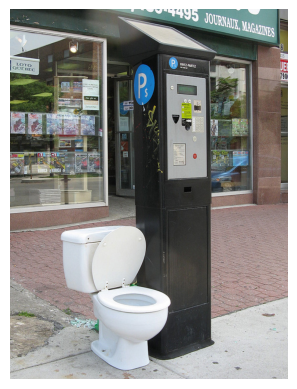

In [ ]:
from PIL import Image
#i = Image.open('/content/train2014/train2014/COCO_train2014_000000078077.jpg')
i = Image.open('/content/download (1).png')
i

In [ ]:
q = "kya is picture ke bare main kuch funny thing hai"
q = tok.texts_to_sequences([q])

In [ ]:
q = sequence.pad_sequences(q,28,padding='post')

In [ ]:
q

array([[   1,   14,   51,    6,  408,    4,  172, 2913,  342,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int32)

In [ ]:
q.shape

(1, 28)

In [ ]:
{ft, q}

TypeError: ignored

In [ ]:
preds = model([features, q])

y_classes = tf.argmax(preds, axis=1, output_type=tf.int32)
y_predict = (labelencoder.inverse_transform(y_classes))

In [ ]:
y_predict

array(['yes'], dtype='<U18')

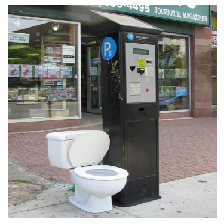

In [ ]:
image_path = '/content/download (1).png'
img = image.load_img(image_path, target_size=(224, 224))
img

##########----------##########

kya is picture ke bare mein kuch funny thing he
1/1 [==============================] - 0s 44ms/step


'yes'

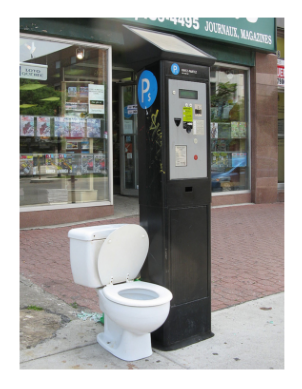

In [ ]:
#@title ## Markdown
#@markdown You can also include Markdown in forms.

#@markdown ---
#@markdown ### Enter a file path:
image_path = "/content/download (1).png" #@param {type:"string"}
question = "kya is picture ke bare mein kuch funny thing he" #@param {type:"string"}
#print(file_path)
#print("a")
i = Image.open(image_path)
plt.imshow(i)
plt.axis("off")
print(question)
img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(img)

# preprocess the image by
# (1) expanding the dimensions to include batch dim and
# (2) subtracting the mean RGB pixel intensity from the ImageNet dataset
img = np.expand_dims(img, axis=0)
img = preprocess_input(img)

features = model2.predict(img)
features = tf.reshape(features, (features.shape[0], features.shape[3], -1)) # (BATCH_SIZE, 512, 49)
features = tf.transpose(features, perm =[0,2,1])

question = tok.texts_to_sequences([question])
question = sequence.pad_sequences(question,28,padding='post')

preds = model([features, question])

y_classes = tf.argmax(preds, axis=1, output_type=tf.int32)
y_predict = (labelencoder.inverse_transform(y_classes))

y_predict[0]
#@markdown ---

